---
**License**

 VexpBounce

 Tue Nov 15 12:13:14 2022\
 Copyright  2022\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 MagDustBounce\
 Copyright (C) 2022 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

# Magnetic field in dust dominated bouncing cosmology

In this notebook we develop the necessary objects to compute the power spectrum (and other observables) for magnetic field production in the contraction phase of a bouncing cosmology dominated by a scalar field.

The scale factor for this model is described at 1706.08830.

The electromagnetic vector field satisfy the following Hamilton equations:
\begin{equation}
\dot{A} = \frac{\Pi_A}{m}, \qquad \dot{\Pi}_A = -m\nu^2 A, \qquad m \equiv \frac{a F}{N},\quad \nu = \frac{Nk}{a},\qquad N = \frac{\mathrm{d}t}{\mathrm{d}\tau}, \qquad \alpha = \alpha_b + \frac{\tau^2}{2},\qquad \alpha = \ln(a), \qquad N = \frac{\tau}{H}.
\end{equation}
for the mode $k$. It is convenient to rewrite $F$ as
\begin{equation}
F\equiv \frac{1}{4}+B e^{-\frac{\phi^2}{\beta^2}}.
\end{equation}


## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries.

In [1]:
from enum import Enum
import gi

gi.require_version("NumCosmo", "1.0")
gi.require_version("NumCosmoMath", "1.0")

# pylint:disable-next=wrong-import-position,unused-import
from gi.repository import GObject  # noqa: E402

# pylint:disable-next=wrong-import-position,unused-import
from gi.repository import NumCosmo as Nc  # noqa: E402

# pylint:disable-next=wrong-import-position,unused-import
from gi.repository import NumCosmoMath as Ncm  # noqa: E402


class GEnum(str, Enum):
    """Enum for GObject enums."""

    def __new__(cls, value):
        name = value.value_nick
        obj = str.__new__(cls, name)
        obj._value_ = name
        return obj

    def __init__(self, genum) -> None:
        super().__init__()
        self.genum = genum


__all__ = ["Nc", "Ncm", "GObject", "GEnum"]

import sys
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import odeint
from scipy.interpolate import interp1d

# Initializing the library

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# Latex definition

In [3]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base == 1.0:
          return r"10^{{{1}}}".format (int(exponent))
        else:
          #return r"{0} \times 10^{{{1}}}".format(base, int(exponent)) # CHECK WHY \TIMES DOESN'T WORK
          return r"{0} x 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

# Model initialization

Creating a new background Vexp model

In [4]:
Vexp = Nc.HICosmoVexp.new ()
Vexp.props.alphab   = 8.3163e-2 # Alpha (# of e-folds) at the bounce
Vexp.props.sigmaphi = 9.0       # Width of the Gaussian solution for the WdW equation
Vexp.props.dphi     = -9.0e-4   # Deviation of the Gaussian solution for the WdW equation
Vexp.props.xb       = 2.0e36    # Inverse of the scale factor at the bounce (Initial condition)
Vexp.props.OmegaL   = 1.0       # H²(a when w=-1)/H²(a0). Basically gives the DE-dominated phase
Vexp.props.Omegac   = 1.0       # Omega_d???
Vexp.props.H0       = 67.8      # Hubble parameter today given by CMB observations

tc = Vexp.tau_xe (1.0e15)       # Initial tau in expansion phase??? tau para quando a expansão é 10^15
reltol = 1.0e-14                # Relative tolerance for solving differential equations
B = 1.0e-58                     # Amplitude of the EM gaussian coupling
beta = 0.08                     # Width of the EM gaussian coupling
k = 1.0                         # Wavenumber

# Model integrated time

Getting the time intervals for the computed model in terms of $\alpha \equiv \ln(a/a_0)$ and $\alpha = \alpha_b + \frac{\tau^2}{2}$.



In [5]:
tau_min = Vexp.tau_min ()   # Get initial time
tau_max = Vexp.tau_max ()   # Get final time
tau_qt_c = Vexp.tau_qt_c()  # Get initial time of the quantum phase
tau_qt_e = Vexp.tau_qt_e()  # Get final time of the quantum phase
npoints = 5000

tau_a = np.linspace (tau_min, tau_max, npoints)
tau_q_a = np.linspace (tau_qt_c, tau_qt_e, npoints)

print (f"Vexp model prepared in the interval ({tau_min},{tau_max})")
print (f"Vexp quantum dominated interval ({tau_qt_c},{tau_qt_e})")

Vexp model prepared in the interval (-23.81538202625965,22.119479531725784)
Vexp quantum dominated interval (-1.009555102588451,2.1913866141271297)


# Consistence check

Plotting $\alpha(\tau) - \alpha_b$.

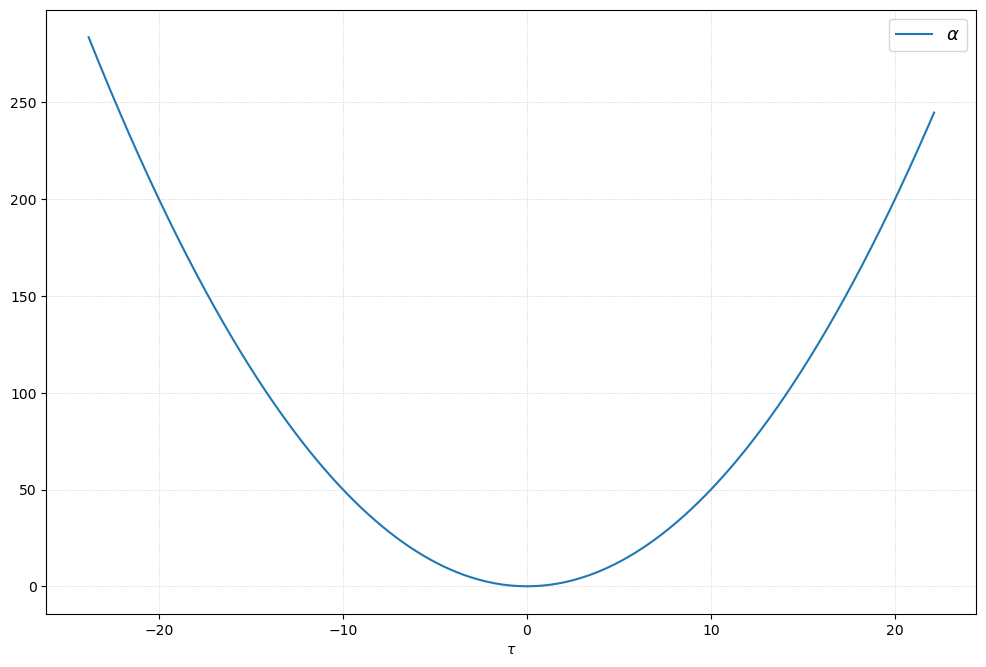

In [6]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

alpha_a = [Vexp.alpha (tau) for tau in tau_a]
#alpha_a_test = [tau*tau/2. for tau in tau_a]

plt.plot (tau_a, alpha_a, label=r"$\alpha$")
#plt.plot (tau_a, alpha_a_test, label=r"$\alpha$",linestyle='dashed')

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel (r"$\tau$")
plt.show()
pass

# Plotting scale factor as a function of tau.

$a(\tau)$

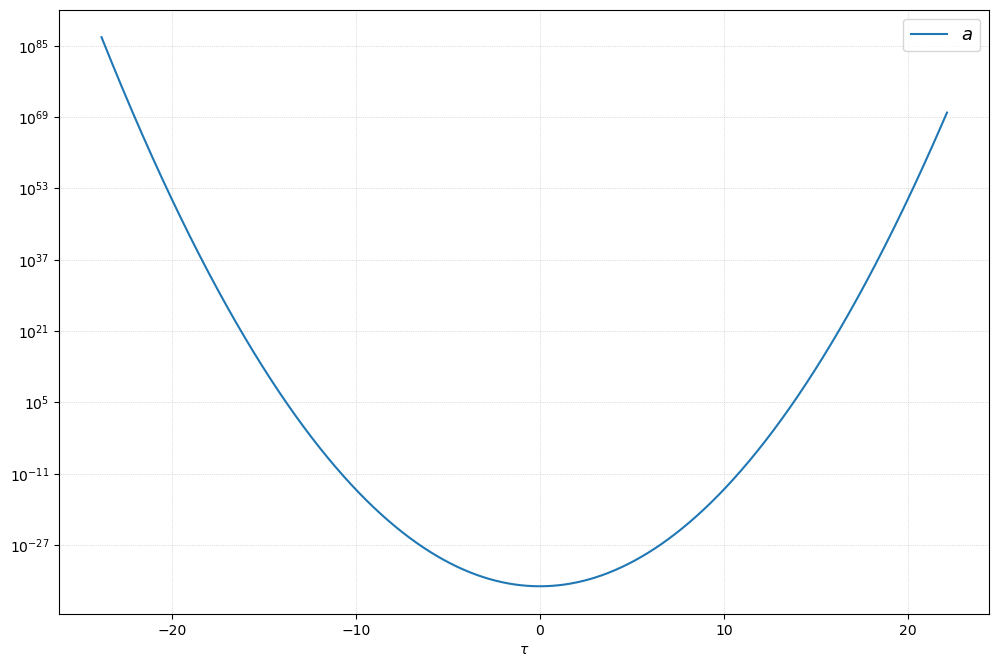

In [7]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

alpha_a = [Vexp.alpha (tau) for tau in tau_a]
#alpha_a_test = [tau*tau/2. for tau in tau_a]

plt.plot (tau_a, np.exp(alpha_a)/Vexp.props.xb, label=r"$a$")
#plt.plot (tau_a, np.exp(alpha_a_test)/2.0e36, label=r"$a$",linestyle='dashed')

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel(r"$\tau$")
plt.yscale("log")
plt.show()
pass

# Plotting the scalar field as a function of tau.

$\phi(\tau)$

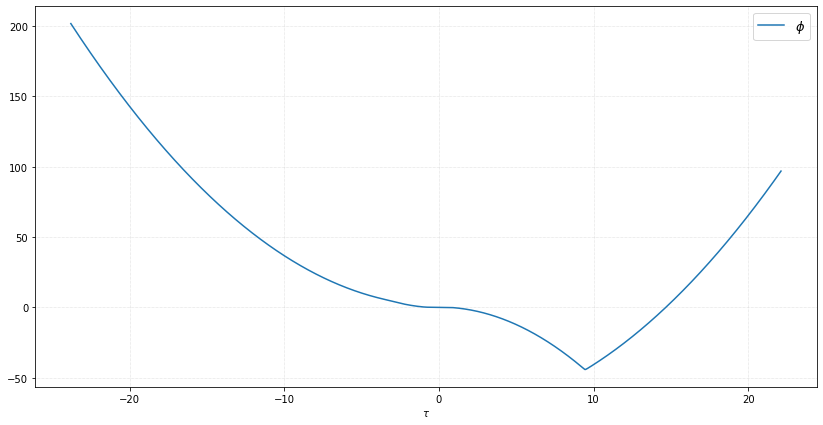

In [8]:
plt.figure (figsize=(14, 7))

phi_a = np.array([Vexp.phi (tau) for tau in tau_a])

plt.plot (tau_a, phi_a, label=r"$\phi$")

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel (r"$\tau$")
plt.show()


# Ploting Ricci scalar and mode frequency.

$R(\tau)$ and $\nu(\tau)$

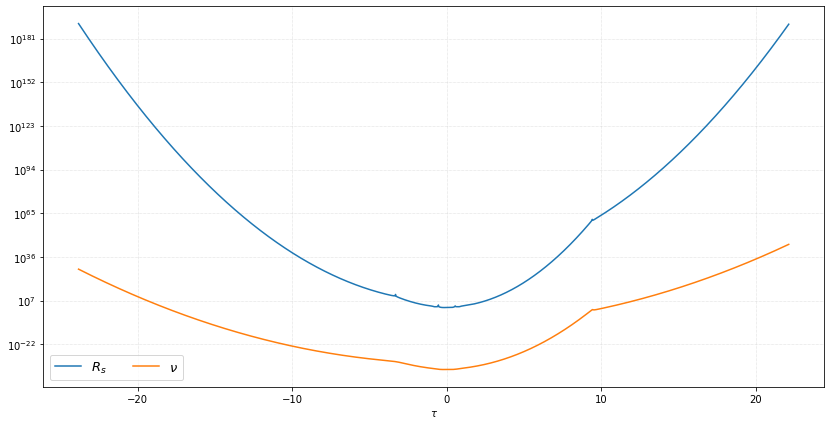

In [10]:
plt.figure (figsize=(14, 7))

RS_a = np.array([Vexp.Ricci_scale (tau) for tau in tau_a]) # Hubble scale goes to 0 at the bounce, but not the Ricci scalar
nu_a = np.array([Vexp.eval_nu (tau, k) for tau in tau_a])

plt.plot (tau_a, RS_a, label=r"$R_s$")
plt.plot (tau_a, nu_a, label=r"$\nu$")

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel (r"$\tau$")
plt.yscale('log')

plt.show()

# Plotting background field variables

$x(\tau)$, $y(\tau)$ and $\sqrt{x^2 + y^2}$.

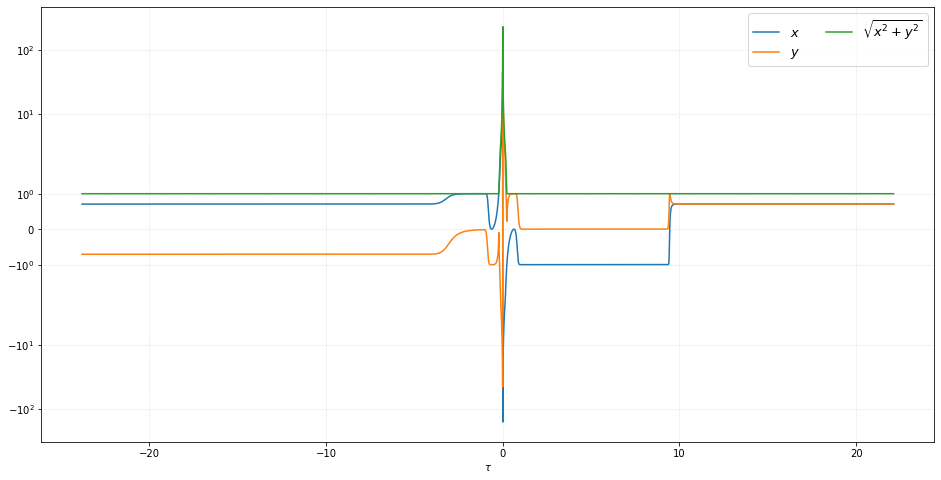

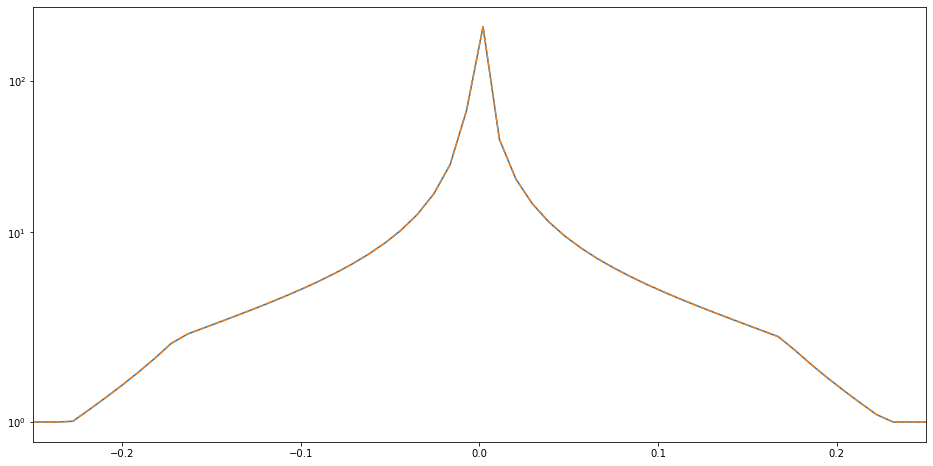

In [11]:
plt.figure (figsize=(16, 8))

x_y_a = np.array ([Vexp.x_y (tau) for tau in tau_a])

plt.plot (tau_a, x_y_a[:,0], label='$x$')
plt.plot (tau_a, x_y_a[:,1], label='$y$')
plt.plot (tau_a, np.hypot(x_y_a[:,0], x_y_a[:,1]), label='$\sqrt{x^2+y^2}$')

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel (r"$\tau$")
plt.yscale('symlog')

plt.show()


# Close-up on the Friedmann constraint in the quantum regime
plt.figure (figsize=(16, 8))

plt.plot (tau_a, np.sqrt(x_y_a[:,0]*x_y_a[:,0]+x_y_a[:,1]*x_y_a[:,1]), label='$x^2+y^2$')
plt.plot (tau_a, np.hypot(x_y_a[:,0], x_y_a[:,1]), label='$\sqrt{x^2+y^2}$',linestyle='dashed')

plt.xlim(-0.25,0.25)
plt.yscale('symlog')

plt.show()


# Plotting magnetic field background quantities 

$\phi(\tau)$, $f(\phi(\tau)) = e^{-\phi^2/\beta^2}$ and the equation of state $w$.

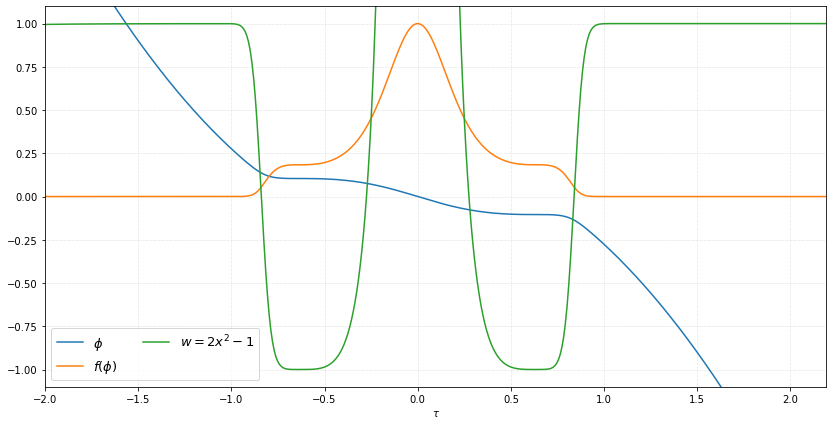

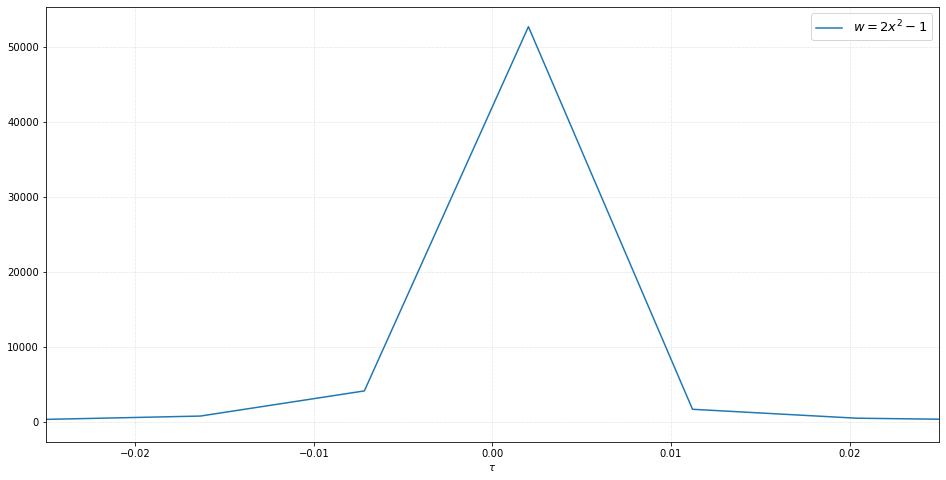

In [13]:
plt.figure (figsize=(14, 7))

plt.plot (tau_a, phi_a, label='$\phi$')
plt.plot (tau_a, np.exp (-(phi_a / beta)**2), label=r'$f(\phi)$')
plt.plot (tau_a, 2.0 * x_y_a[:,0]**2-1.0, label='$w = 2x^2-1$')

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel (r"$\tau$")
#plt.yscale('symlog')
plt.xlim(-2.0, tau_qt_e)
plt.ylim(-1.1, 1.1)

plt.show()

###
### Equation of state
###

plt.figure (figsize=(16, 8))

plt.plot (tau_a, 2.0 * x_y_a[:,0]**2-1.0, label='$w = 2x^2-1$')

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)
plt.xlim(-0.025, 0.025)
plt.xlabel (r"$\tau$")
            
plt.show()

# Defines the electromagnetic field model

This model use the Complex Structure Quantization method CSQ1D.

In [7]:
class PyCSQ1DMagScalarField (Ncm.CSQ1D):
  def __init__ (self, B, beta):
    Ncm.CSQ1D.__init__ (self)
    self.B = B
    self.beta = beta

  def do_eval_xi (self, model, t, k):
    return model.eval_xi (t, k, self.B, self.beta)

  def do_eval_nu (self, model, t, k):
    return model.eval_nu (t, k)

  def do_eval_nu2 (self, model, t, k):
    return model.eval_nu (t, k)**2

  def do_eval_m (self, model, t, k):
    return model.eval_m (t, self.B, self.beta)

  def do_eval_F1 (self, model, t, k):
    return model.eval_F1 (t, k, self.B, self.beta)

  def do_prepare (self, model):
    pass 

  def eval_PB_PE (self, model, t):
    J11, _, J22 = self.get_J_at (model, t)
    A2   = 0.5 * J11
    PiA2 = 0.5 * J22
    
    alpha = model.alpha (t)
    y     = np.exp(alpha) / model.props.xb
    RH    = model.RH_Mpc()
    k     = self.get_k()
    m     = model.eval_m (t, self.B, self.beta)
    PE    = PiA2   * (k / y)**3 / (2.0 * math.pi**2 * RH**4 * m)
    PB    = m * A2 * (k / y)**5 / (2.0 * math.pi**2 * RH**4)

    return PB, PE, J11, J22

# Setting up models

Setting up two models, the benchmark with no ($10^{-50}$) coupling as model 0 and the model with coupling as model 1.

In [8]:
k = 1.0e0

B0 = 1.0e-50
beta0 = 8.0e-1
B1 = 1.0e50
beta1 = 8.0e-1

csq1d0 = PyCSQ1DMagScalarField (B0, beta0)
csq1d0.set_k (k)
csq1d1 = PyCSQ1DMagScalarField (B1, beta1)
csq1d1.set_k (k)


# Finding starting point as the end of the adiabatic phase

Setting limit for the adiabatic phase with $10^{-9}$.

In [9]:
print(f"Searching for WKB scale in ({tau_min}, {tau_qt_c})")

(Found_tau_i0, tau_i0) = csq1d0.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
(Found_tau_i1, tau_i1) = csq1d1.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)



(process:26172): NUMCOSMO-WARNING **: 15:58:53.927: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 15:58:53.944: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 15:58:53.947: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 15:58:53.956: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 15:58:53.965: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800619628503e+38 and |F4/F3| =   2.68556303081983e+40 at t = -1.000000000000000e-02. Truncating series at F

# Checking if the search for the starting time was successful 

In [10]:
tau_f = 10.0


print(F"Found ({Found_tau_i0}) WKB scale at {tau_i0} (B = {B0}, beta = {beta0})")
print(F"Found ({Found_tau_i1}) WKB scale at {tau_i1} (B = {B1}, beta = {beta1})")

# print(csq1d0.eval_F1 (Vexp, tau_i0, k))
# print(csq1d1.eval_F1 (Vexp, tau_i1, k))

# print(csq1d0.eval_adiab_at(Vexp, tau_i0))
# print(csq1d1.eval_adiab_at(Vexp, tau_i1))


Found (True) WKB scale at -3.8220614651365072 (B = 1e-50, beta = 0.8)
Found (True) WKB scale at -5.885926984544123 (B = 1e+50, beta = 0.8)


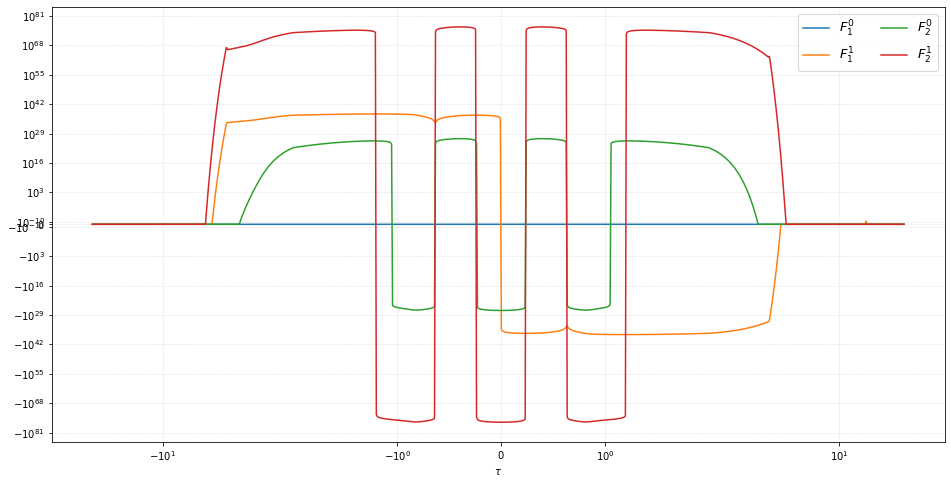

In [22]:
plt.figure (figsize=(16, 8))

tau_ad_a = np.linspace(-1.35, -1.0, 100)
tau_ad_a = tau_a

F1_a0 = np.array ([csq1d0.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
F2_a0 = np.array ([csq1d0.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
nu_a0 = np.array ([csq1d0.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

F1_a1 = np.array ([csq1d1.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
F2_a1 = np.array ([csq1d1.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
nu_a1 = np.array ([csq1d1.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

plt.plot (tau_ad_a, F1_a0, label=r"$F^0_1$")
plt.plot (tau_ad_a, F1_a1, label=r"$F^1_1$")
plt.plot (tau_ad_a, F2_a0, label=r"$F^0_2$")
plt.plot (tau_ad_a, F2_a1, label=r"$F^1_2$")

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel (r"$\tau$")
plt.xscale('symlog')
plt.yscale('symlog', linthresh=1.0e-10)

plt.show()

tau_i = -0.94
tau_f = 5.0
print(csq1d0.eval_adiab_at (Vexp, tau_i))
print(csq1d1.eval_adiab_at (Vexp, tau_i))

In [11]:
csq1d0.set_init_cond_adiab (Vexp, tau_i0)
csq1d1.set_init_cond_adiab (Vexp, tau_i1)


(process:26172): NUMCOSMO-WARNING **: 15:58:58.677: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.39720698727891e+34 and |F4/F3| =   2.47047935130668e+34 at t = -3.822061465136507e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 15:58:58.689: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   3.11143711788984e+32 and |F4/F3| =   3.15675888533406e+32 at t = -5.885926984544123e+00. Truncating series at F2.



In [12]:
csq1d0.set_ti (tau_i0)
csq1d0.set_tf (tau_f)
csq1d0.prepare (Vexp)

csq1d1.set_ti (tau_i1)
csq1d1.set_tf (tau_f)
csq1d1.prepare (Vexp)

tau_evol_a0, tau_s0 = csq1d0.get_time_array ()
tau_evol_a0 = np.array (tau_evol_a0)

tau_evol_a1, tau_s1 = csq1d1.get_time_array ()
tau_evol_a1 = np.array (tau_evol_a1)

In [13]:
PB_a0 = []
PE_a0 = []
J11_a0 = []
J22_a0 = []

PB_a1 = []
PE_a1 = []
J11_a1 = []
J22_a1 = []

for tau in tau_evol_a0:
    PB, PE, J11, J22 = csq1d0.eval_PB_PE (Vexp, tau)
    PB_a0.append(PB)
    PE_a0.append(PE)
    J11_a0.append(J11)
    J22_a0.append(J22)

for tau in tau_evol_a1:
    PB, PE, J11, J22 = csq1d1.eval_PB_PE (Vexp, tau)
    PB_a1.append(PB)
    PE_a1.append(PE)
    J11_a1.append(J11)
    J22_a1.append(J22)

PB_a0 = np.array(PB_a0)
PE_a0 = np.array(PE_a0)
J11_a0 = np.array(J11_a0)
J22_a0 = np.array(J22_a0)

PB_a1 = np.array(PB_a1)
PE_a1 = np.array(PE_a1)
J11_a1 = np.array(J11_a1)
J22_a1 = np.array(J22_a1)

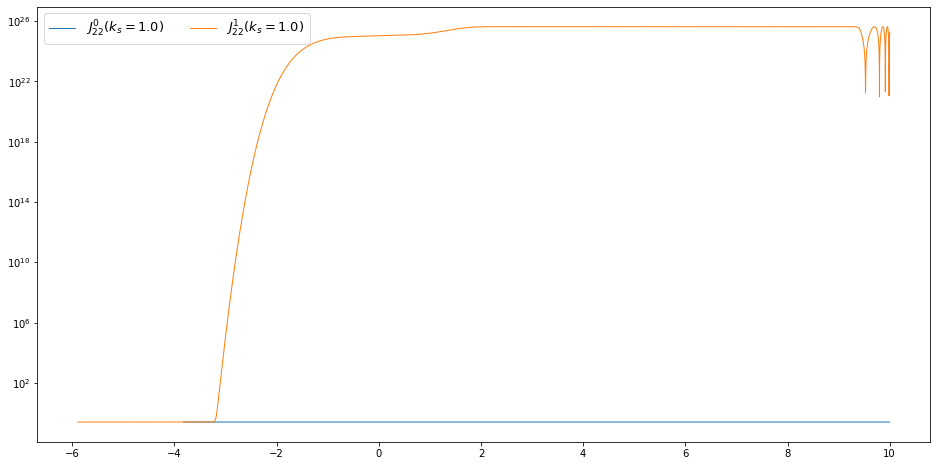

NameError: name 'k_a' is not defined

<Figure size 1152x576 with 0 Axes>

In [15]:
plt.figure (figsize=(16, 8))

mylw = 1

plt.plot (tau_evol_a0, J22_a0, lw=mylw, label = f'$J^0_{{22}}(k_s = {k})$')
plt.plot (tau_evol_a1, J22_a1, lw=mylw, label = f'$J^1_{{22}}(k_s = {k})$')

leg = plt.legend (loc="best", ncol = 2, fontsize=13)
plt.yscale("log")
plt.show()

# Loop over k (TO FIX: same J for k=1 and k=4.000)

# plt.figure (figsize=(16, 8))

# mylw = 1

# for k in k_a:
    
#     plt.plot (tau_evol_a0, J22_a0, lw=mylw, label = f'$J^0_{{22}}(k_s = %s)$'% latex_float (k))
#     plt.plot (tau_evol_a1, J22_a1, lw=mylw, label = f'$J^1_{{22}}(k_s = %s)$'% latex_float (k))

# leg = plt.legend (loc="best", ncol = 2, fontsize=13)
# plt.yscale("log")

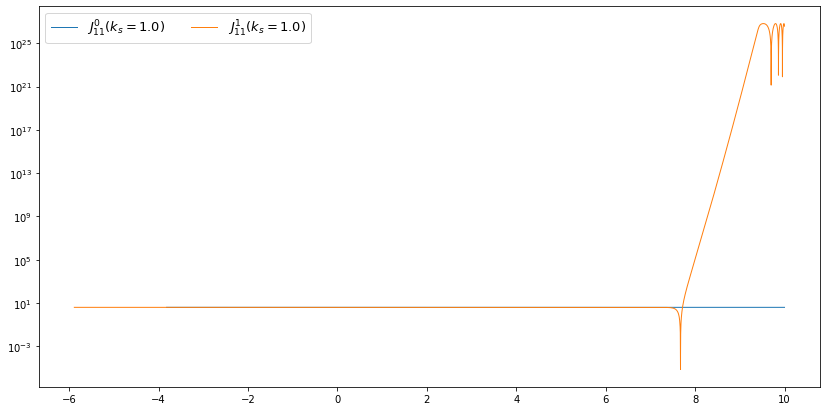

In [16]:
plt.figure (figsize=(14, 7))

mylw = 1

plt.plot (tau_evol_a0, J11_a0, lw=mylw, label = f'$J^0_{{11}}(k_s = {k})$')
plt.plot (tau_evol_a1, J11_a1, lw=mylw, label = f'$J^1_{{11}}(k_s = {k})$')

leg = plt.legend (loc="best", ncol = 2, fontsize=13)
plt.yscale("log")

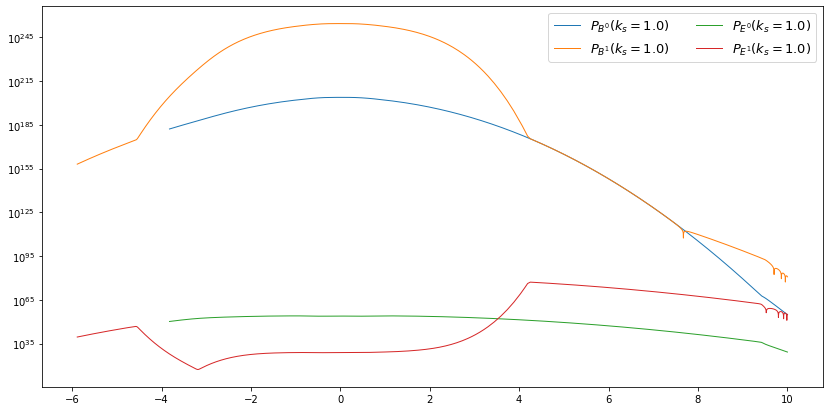

In [17]:
plt.figure (figsize=(14, 7))

mylw = 1

plt.plot (tau_evol_a0, PB_a0, lw=mylw, label = f'$P_{{B^0}}(k_s = {k})$')
plt.plot (tau_evol_a1, PB_a1, lw=mylw, label = f'$P_{{B^1}}(k_s = {k})$')

plt.plot (tau_evol_a0, PE_a0, lw=mylw, label = f'$P_{{E^0}}(k_s = {k})$')
plt.plot (tau_evol_a1, PE_a1, lw=mylw, label = f'$P_{{E^1}}(k_s = {k})$')

leg = plt.legend (loc="best", ncol = 2, fontsize=13)
plt.yscale("log")
#plt.xlim(-19.0,-17.0)
#plt.ylim(1.0e-260,1.0e-90)

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
4.506724599333284e-44
3.2613822434225763e-42



(process:25729): NUMCOSMO-WARNING **: 15:55:53.280: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:25729): NUMCOSMO-WARNING **: 15:55:53.288: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:53.290: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:25729): NUMCOSMO-WARNING **: 15:55:53.297: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:53.305: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800619628503e+38 and |F4/F3| =   2.68556303081983e+40 at t = -1.000000000000000e-02. Truncating series at F

(alpha=4.506724599333284e-44, dgamma=-1.047909884633588e-09, alpha_reltol=4.506724599333284e-44, dgamma_reltol=1.047909884633588e-09)
(alpha=3.2613822434225763e-42, dgamma=-9.99999228968526e-10, alpha_reltol=3.2613822434225763e-42, dgamma_reltol=9.99999228968526e-10)



(process:25729): NUMCOSMO-WARNING **: 15:55:53.483: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.39720698727891e+34 and |F4/F3| =   2.47047935130668e+34 at t = -3.822061465136507e+00. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:53.496: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   3.11143711788984e+32 and |F4/F3| =   3.15675888533406e+32 at t = -5.885926984544123e+00. Truncating series at F2.



Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
1.52296700149939e-42
1.8269034539918249e-40
(alpha=1.52296700149939e-42, dgamma=-7.248432903776602e-10, alpha_reltol=1.52296700149939e-42, dgamma_reltol=7.248432903776602e-10)
(alpha=1.8269034539918249e-40, dgamma=-9.999879950010497e-10, alpha_reltol=1.8269034539918249e-40, dgamma_reltol=9.999879950010497e-10)



(process:25729): NUMCOSMO-WARNING **: 15:55:54.310: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:25729): NUMCOSMO-WARNING **: 15:55:54.318: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.81515717438622e+36 and |F4/F3| =   4.24624495482779e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:54.319: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:25729): NUMCOSMO-WARNING **: 15:55:54.327: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.81515717438622e+36 and |F4/F3| =   4.24624495482779e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:54.335: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.81515714807863e+36 and |F4/F3| =   4.24624154565451e+38 at t = -1.000000000000000e-02. Truncating series at F

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)



(process:25729): NUMCOSMO-WARNING **: 15:55:55.321: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:25729): NUMCOSMO-WARNING **: 15:55:55.329: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:55.330: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:25729): NUMCOSMO-WARNING **: 15:55:55.338: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:55.346: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001543104818e+34 and |F4/F3| =   6.71391134250349e+36 at t = -1.000000000000000e-02. Truncating series at F

9.353633979745823e-41
1.0217445306011118e-38
(alpha=9.353633979745823e-41, dgamma=-9.999999999997676e-10, alpha_reltol=9.353633979745823e-41, dgamma_reltol=9.999999999997676e-10)
(alpha=1.0217445306011118e-38, dgamma=-9.99907380410051e-10, alpha_reltol=1.0217445306011118e-38, dgamma_reltol=9.99907380410051e-10)



(process:25729): NUMCOSMO-WARNING **: 15:55:55.529: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.12164933093538e+31 and |F4/F3| =   1.17614808661849e+31 at t = -3.520338461293310e+00. Truncating series at F2.


(process:25729): NUMCOSMO-WARNING **: 15:55:55.542: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   9.93439593214983e+28 and |F4/F3| =   1.00827467092286e+29 at t = -5.792503260849855e+00. Truncating series at F2.



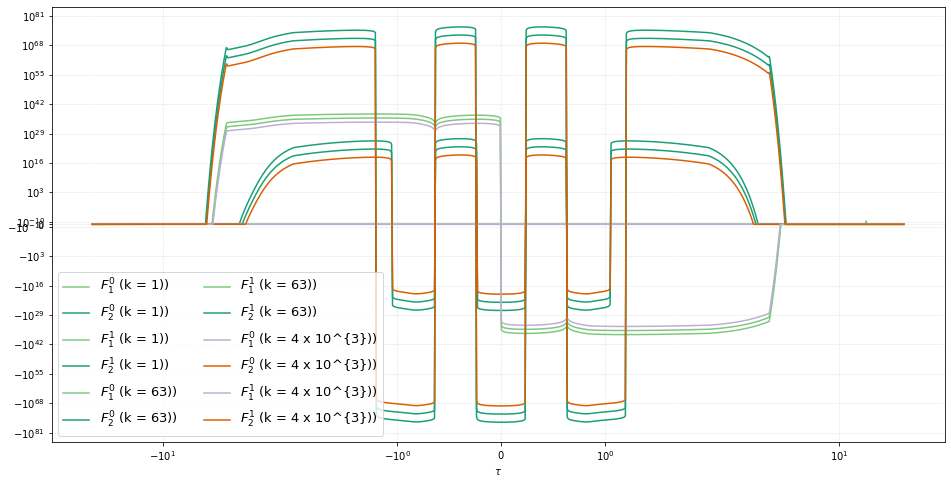

In [25]:
###
### Loop over k
###

ki    = 1.0
kf    = 4.0e3
k_a   = np.geomspace (ki, kf, 3)

B0 = 1.0e-50
beta0 = 8.0e-1
B1 = 1.0e50
beta1 = 8.0e-1

csq1d0 = PyCSQ1DMagScalarField (B0, beta0)
csq1d1 = PyCSQ1DMagScalarField (B1, beta1)

# Define map colours for easier visualisation
# Maps are defined there: https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormapF1a0= plt.get_cmap('Accent')
colorsF1a0 = iter(colormapF1a0(np.linspace(0,1,10)))
colormapF1a1= plt.get_cmap('Accent')
colorsF1a1 = iter(colormapF1a1(np.linspace(0,1,10)))
colormapF2a0= plt.get_cmap('Dark2')
colorsF2a0 = iter(colormapF2a0(np.linspace(0,1,10)))
colormapF2a1= plt.get_cmap('Dark2')
colorsF2a1 = iter(colormapF2a1(np.linspace(0,1,10)))

plt.figure (figsize=(16, 8))

for k in k_a:
    csq1d0.set_k (k)
    csq1d1.set_k (k)
    
    print(f"Searching for WKB scale in ({tau_min}, {tau_qt_c})")

    (Found_tau_i0, tau_i0) = csq1d0.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    (Found_tau_i1, tau_i1) = csq1d1.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    
    print(csq1d0.eval_F1 (Vexp, tau_i0, k))
    print(csq1d1.eval_F1 (Vexp, tau_i1, k))

    print(csq1d0.eval_adiab_at(Vexp, tau_i0))
    print(csq1d1.eval_adiab_at(Vexp, tau_i1))
    
    F1_a0 = np.array ([csq1d0.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a0 = np.array ([csq1d0.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a0 = np.array ([csq1d0.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

    #F1_a1 = np.array ([csq1d1.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    #F2_a1 = np.array ([csq1d1.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    #nu_a1 = np.array ([csq1d1.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

    plt.plot (tau_ad_a, F1_a0, label=r"$F^0_1$ (k = %s))"% latex_float (k),color=next(colorsF1a0))
    #plt.plot (tau_ad_a, F1_a1, label=r"$F^1_1$ (k = %s))"% latex_float (k),color=next(colorsF1a1))
    plt.plot (tau_ad_a, F2_a0, label=r"$F^0_2$ (k = %s))"% latex_float (k),color=next(colorsF2a0))
    #plt.plot (tau_ad_a, F2_a1, label=r"$F^1_2$ (k = %s))"% latex_float (k),color=next(colorsF2a1))
    
#     F1_a0 = np.array ([csq1d0.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
#     F2_a0 = np.array ([csq1d0.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
#     nu_a0 = np.array ([csq1d0.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

    F1_a1 = np.array ([csq1d1.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a1 = np.array ([csq1d1.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a1 = np.array ([csq1d1.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

#    plt.plot (tau_ad_a, F1_a0, label=r"$F^0_1$ (k = %s))"% latex_float (k),color=next(colorsF1a0))
    plt.plot (tau_ad_a, F1_a1, label=r"$F^1_1$ (k = %s))"% latex_float (k),color=next(colorsF1a1))
#    plt.plot (tau_ad_a, F2_a0, label=r"$F^0_2$ (k = %s))"% latex_float (k),color=next(colorsF2a0))
    plt.plot (tau_ad_a, F2_a1, label=r"$F^1_2$ (k = %s))"% latex_float (k),color=next(colorsF2a1))

plt.grid (visible=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2, fontsize=13)

plt.xlabel (r"$\tau$")
plt.xscale('symlog')
plt.yscale('symlog', linthresh=1.0e-10)

plt.show()

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
4.506724599333284e-44
3.2613822434225763e-42



(process:26172): NUMCOSMO-WARNING **: 16:05:31.699: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:05:31.707: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:31.709: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:05:31.717: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:31.725: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800619628503e+38 and |F4/F3| =   2.68556303081983e+40 at t = -1.000000000000000e-02. Truncating series at F

(alpha=4.506724599333284e-44, dgamma=-1.047909884633588e-09, alpha_reltol=4.506724599333284e-44, dgamma_reltol=1.047909884633588e-09)
(alpha=3.2613822434225763e-42, dgamma=-9.99999228968526e-10, alpha_reltol=3.2613822434225763e-42, dgamma_reltol=9.99999228968526e-10)



(process:26172): NUMCOSMO-WARNING **: 16:05:32.689: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.39720698727891e+34 and |F4/F3| =   2.47047935130668e+34 at t = -3.822061465136507e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.699: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   3.11143711788984e+32 and |F4/F3| =   3.15675888533406e+32 at t = -5.885926984544123e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.787: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.794: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.81515717438622e+36 and |F4/F3| =   4.24624495482779e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.795: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate erro

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
1.52296700149939e-42
1.8269034539918249e-40
(alpha=1.52296700149939e-42, dgamma=-7.248432903776602e-10, alpha_reltol=1.52296700149939e-42, dgamma_reltol=7.248432903776602e-10)
(alpha=1.8269034539918249e-40, dgamma=-9.999879950010497e-10, alpha_reltol=1.8269034539918249e-40, dgamma_reltol=9.999879950010497e-10)



(process:26172): NUMCOSMO-WARNING **: 16:05:32.891: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.77260411378872e+36 and |F4/F3| =   4.24688478857977e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.902: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   4.02415224286069e+30 and |F4/F3| =   4.08161201067246e+30 at t = -5.961345506564911e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.912: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.95346486365382e+31 and |F4/F3| =   1.98652779482351e+31 at t = -5.333042951070135e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.923: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =    5.7817120167009e+30 and |F4/F3| =   5.86731709456543e+30 at t = -5.824463883040052e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:32.935: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2|

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)



(process:26172): NUMCOSMO-WARNING **: 16:05:34.310: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:05:34.319: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:34.321: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:05:34.329: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:34.337: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001543104818e+34 and |F4/F3| =   6.71391134250349e+36 at t = -1.000000000000000e-02. Truncating series at F

9.353633979745823e-41
1.0217445306011118e-38
(alpha=9.353633979745823e-41, dgamma=-9.999999999997676e-10, alpha_reltol=9.353633979745823e-41, dgamma_reltol=9.999999999997676e-10)
(alpha=1.0217445306011118e-38, dgamma=-9.99907380410051e-10, alpha_reltol=1.0217445306011118e-38, dgamma_reltol=9.99907380410051e-10)



(process:26172): NUMCOSMO-WARNING **: 16:05:34.522: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   9.93439593214983e+28 and |F4/F3| =   1.00827467092286e+29 at t = -5.792503260849855e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:34.530: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.12164933093538e+31 and |F4/F3| =   1.17614808661849e+31 at t = -3.520338461293310e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:34.543: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   9.93439593214983e+28 and |F4/F3| =   1.00827467092286e+29 at t = -5.792503260849855e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:35.377: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.12164933093538e+31 and |F4/F3| =   1.17614808661849e+31 at t = -3.520338461293310e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:05:35.389: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2|

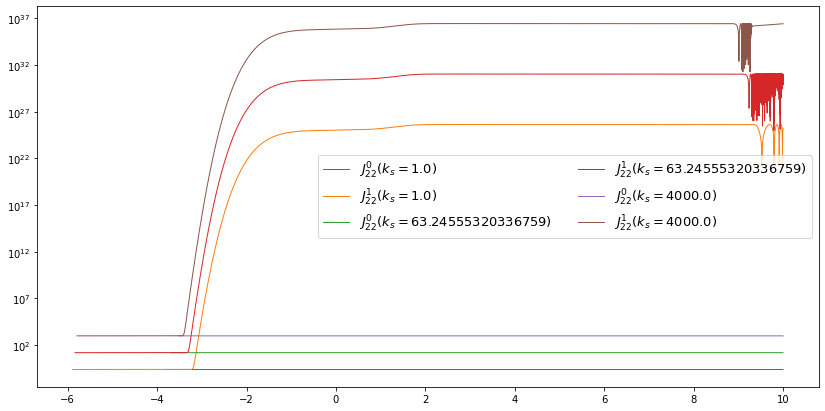

In [20]:
ki    = 1.0
kf    = 4.0e3
k_a   = np.geomspace (ki, kf, 3)

B0 = 1.0e-50
beta0 = 8.0e-1
B1 = 1.0e50
beta1 = 8.0e-1

csq1d0 = PyCSQ1DMagScalarField (B0, beta0)
csq1d1 = PyCSQ1DMagScalarField (B1, beta1)

# Define map colours for easier visualisation
# Maps are defined there: https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormapF1a0= plt.get_cmap('Accent')
colorsF1a0 = iter(colormapF1a0(np.linspace(0,1,10)))
colormapF1a1= plt.get_cmap('Accent')
colorsF1a1 = iter(colormapF1a1(np.linspace(0,1,10)))
colormapF2a0= plt.get_cmap('Dark2')
colorsF2a0 = iter(colormapF2a0(np.linspace(0,1,10)))
colormapF2a1= plt.get_cmap('Dark2')
colorsF2a1 = iter(colormapF2a1(np.linspace(0,1,10)))

tau_ad_a = np.linspace(-1.35, -1.0, 100)
tau_ad_a = tau_a

plt.figure (figsize=(14, 7))

mylw = 1

for k in k_a:
    csq1d0.set_k (k)
    csq1d1.set_k (k)
    
    print(f"Searching for WKB scale in ({tau_min}, {tau_qt_c})")

    (Found_tau_i0, tau_i0) = csq1d0.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    (Found_tau_i1, tau_i1) = csq1d1.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    
    print(csq1d0.eval_F1 (Vexp, tau_i0, k))
    print(csq1d1.eval_F1 (Vexp, tau_i1, k))

    print(csq1d0.eval_adiab_at(Vexp, tau_i0))
    print(csq1d1.eval_adiab_at(Vexp, tau_i1))
    
    F1_a0 = np.array ([csq1d0.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a0 = np.array ([csq1d0.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a0 = np.array ([csq1d0.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

    F1_a1 = np.array ([csq1d1.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a1 = np.array ([csq1d1.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a1 = np.array ([csq1d1.eval_nu (Vexp, tau, k) for tau in tau_ad_a])
    
    csq1d0.set_init_cond_adiab (Vexp, tau_i0)
    csq1d1.set_init_cond_adiab (Vexp, tau_i1)
    
    csq1d0.set_ti (tau_i0)
    csq1d0.set_tf (tau_f)
    csq1d0.prepare (Vexp)

    csq1d1.set_ti (tau_i1)
    csq1d1.set_tf (tau_f)
    csq1d1.prepare (Vexp)

    tau_evol_a0, tau_s0 = csq1d0.get_time_array ()
    tau_evol_a0 = np.array (tau_evol_a0)

    tau_evol_a1, tau_s1 = csq1d1.get_time_array ()
    tau_evol_a1 = np.array (tau_evol_a1)
    
    PB_a0 = []
    PE_a0 = []
    J11_a0 = []
    J22_a0 = []

    PB_a1 = []
    PE_a1 = []
    J11_a1 = []
    J22_a1 = []

    for tau in tau_evol_a0:
        PB, PE, J11, J22 = csq1d0.eval_PB_PE (Vexp, tau)
        PB_a0.append(PB)
        PE_a0.append(PE)
        J11_a0.append(J11)
        J22_a0.append(J22)

    for tau in tau_evol_a1:
        PB, PE, J11, J22 = csq1d1.eval_PB_PE (Vexp, tau)
        PB_a1.append(PB)
        PE_a1.append(PE)
        J11_a1.append(J11)
        J22_a1.append(J22)

    PB_a0 = np.array(PB_a0)
    PE_a0 = np.array(PE_a0)
    J11_a0 = np.array(J11_a0)
    J22_a0 = np.array(J22_a0)

    PB_a1 = np.array(PB_a1)
    PE_a1 = np.array(PE_a1)
    J11_a1 = np.array(J11_a1)
    J22_a1 = np.array(J22_a1)
    
    plt.plot (tau_evol_a0, J22_a0, lw=mylw, label = f'$J^0_{{22}}(k_s = {k})$')
    plt.plot (tau_evol_a1, J22_a1, lw=mylw, label = f'$J^1_{{22}}(k_s = {k})$')

leg = plt.legend (loc="best", ncol = 2, fontsize=13)
plt.yscale("log")
plt.show()

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
4.506724599333284e-44
3.2613822434225763e-42



(process:26172): NUMCOSMO-WARNING **: 16:06:50.807: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:06:50.815: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:50.817: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:06:50.826: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:50.836: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800619628503e+38 and |F4/F3| =   2.68556303081983e+40 at t = -1.000000000000000e-02. Truncating series at F

(alpha=4.506724599333284e-44, dgamma=-1.047909884633588e-09, alpha_reltol=4.506724599333284e-44, dgamma_reltol=1.047909884633588e-09)
(alpha=3.2613822434225763e-42, dgamma=-9.99999228968526e-10, alpha_reltol=3.2613822434225763e-42, dgamma_reltol=9.99999228968526e-10)



(process:26172): NUMCOSMO-WARNING **: 16:06:51.015: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.39720698727891e+34 and |F4/F3| =   2.47047935130668e+34 at t = -3.822061465136507e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:51.027: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   3.11143711788984e+32 and |F4/F3| =   3.15675888533406e+32 at t = -5.885926984544123e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:51.889: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.39720698727891e+34 and |F4/F3| =   2.47047935130668e+34 at t = -3.822061465136507e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:51.900: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   3.11143711788984e+32 and |F4/F3| =   3.15675888533406e+32 at t = -5.885926984544123e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:52.003: WKB series with F1 = 0 or F2 = 0 at t = -2.38153820

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
1.52296700149939e-42
1.8269034539918249e-40
(alpha=1.52296700149939e-42, dgamma=-7.248432903776602e-10, alpha_reltol=1.52296700149939e-42, dgamma_reltol=7.248432903776602e-10)



(process:26172): NUMCOSMO-WARNING **: 16:06:52.091: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:06:52.100: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.77257898553268e+36 and |F4/F3| =   4.24694177922354e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:52.109: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.77258377583882e+36 and |F4/F3| =   4.24693119888412e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:52.111: WKB series with F1 = 0 or F2 = 0 at t = -1.191269101312982e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:06:52.120: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.77260411378872e+36 and |F4/F3| =   4.24688478857977e+38 at t = -1.000000000000000e-02. Truncating series at F

(alpha=1.8269034539918249e-40, dgamma=-9.999879950010497e-10, alpha_reltol=1.8269034539918249e-40, dgamma_reltol=9.999879950010497e-10)



(process:26172): NUMCOSMO-WARNING **: 16:06:53.057: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   4.93556281143183e+32 and |F4/F3| =   5.11658152548173e+32 at t = -3.682464682852223e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:53.069: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   5.55547470035385e+30 and |F4/F3| =   5.63739589376482e+30 at t = -5.839730242512626e+00. Truncating series at F2.



Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
9.353633979745823e-41
1.0217445306011118e-38
(alpha=9.353633979745823e-41, dgamma=-9.999999999997676e-10, alpha_reltol=9.353633979745823e-41, dgamma_reltol=9.999999999997676e-10)



(process:26172): NUMCOSMO-WARNING **: 16:06:53.524: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:06:53.532: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:53.533: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:06:53.541: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:53.548: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001543104818e+34 and |F4/F3| =   6.71391134250349e+36 at t = -1.000000000000000e-02. Truncating series at F

(alpha=1.0217445306011118e-38, dgamma=-9.99907380410051e-10, alpha_reltol=1.0217445306011118e-38, dgamma_reltol=9.99907380410051e-10)



(process:26172): NUMCOSMO-WARNING **: 16:06:53.730: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   9.93439593214983e+28 and |F4/F3| =   1.00827467092286e+29 at t = -5.792503260849855e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:54.571: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.12164933093538e+31 and |F4/F3| =   1.17614808661849e+31 at t = -3.520338461293310e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:06:54.582: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   9.93439593214983e+28 and |F4/F3| =   1.00827467092286e+29 at t = -5.792503260849855e+00. Truncating series at F2.



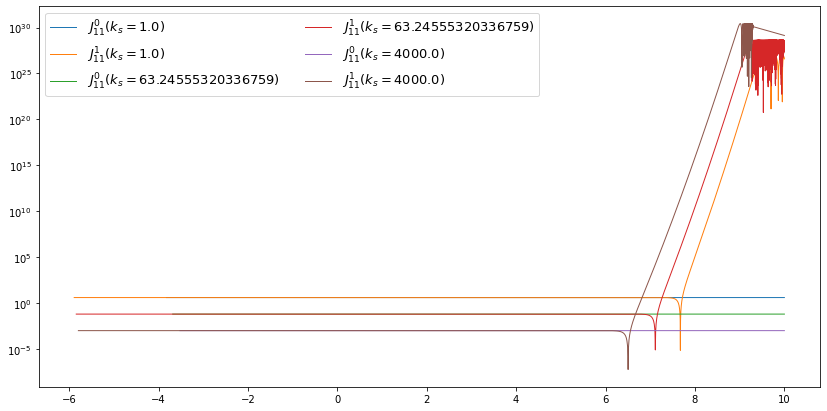

In [21]:
ki    = 1.0
kf    = 4.0e3
k_a   = np.geomspace (ki, kf, 3)

B0 = 1.0e-50
beta0 = 8.0e-1
B1 = 1.0e50
beta1 = 8.0e-1

csq1d0 = PyCSQ1DMagScalarField (B0, beta0)
csq1d1 = PyCSQ1DMagScalarField (B1, beta1)

# Define map colours for easier visualisation
# Maps are defined there: https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormapF1a0= plt.get_cmap('Accent')
colorsF1a0 = iter(colormapF1a0(np.linspace(0,1,10)))
colormapF1a1= plt.get_cmap('Accent')
colorsF1a1 = iter(colormapF1a1(np.linspace(0,1,10)))
colormapF2a0= plt.get_cmap('Dark2')
colorsF2a0 = iter(colormapF2a0(np.linspace(0,1,10)))
colormapF2a1= plt.get_cmap('Dark2')
colorsF2a1 = iter(colormapF2a1(np.linspace(0,1,10)))

tau_ad_a = np.linspace(-1.35, -1.0, 100)
tau_ad_a = tau_a

plt.figure (figsize=(14, 7))

mylw = 1

for k in k_a:
    csq1d0.set_k (k)
    csq1d1.set_k (k)
    
    print(f"Searching for WKB scale in ({tau_min}, {tau_qt_c})")

    (Found_tau_i0, tau_i0) = csq1d0.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    (Found_tau_i1, tau_i1) = csq1d1.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    
    print(csq1d0.eval_F1 (Vexp, tau_i0, k))
    print(csq1d1.eval_F1 (Vexp, tau_i1, k))

    print(csq1d0.eval_adiab_at(Vexp, tau_i0))
    print(csq1d1.eval_adiab_at(Vexp, tau_i1))
    
    F1_a0 = np.array ([csq1d0.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a0 = np.array ([csq1d0.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a0 = np.array ([csq1d0.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

    F1_a1 = np.array ([csq1d1.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a1 = np.array ([csq1d1.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a1 = np.array ([csq1d1.eval_nu (Vexp, tau, k) for tau in tau_ad_a])
    
    csq1d0.set_init_cond_adiab (Vexp, tau_i0)
    csq1d1.set_init_cond_adiab (Vexp, tau_i1)
    
    csq1d0.set_ti (tau_i0)
    csq1d0.set_tf (tau_f)
    csq1d0.prepare (Vexp)

    csq1d1.set_ti (tau_i1)
    csq1d1.set_tf (tau_f)
    csq1d1.prepare (Vexp)

    tau_evol_a0, tau_s0 = csq1d0.get_time_array ()
    tau_evol_a0 = np.array (tau_evol_a0)

    tau_evol_a1, tau_s1 = csq1d1.get_time_array ()
    tau_evol_a1 = np.array (tau_evol_a1)
    
    PB_a0 = []
    PE_a0 = []
    J11_a0 = []
    J22_a0 = []

    PB_a1 = []
    PE_a1 = []
    J11_a1 = []
    J22_a1 = []

    for tau in tau_evol_a0:
        PB, PE, J11, J22 = csq1d0.eval_PB_PE (Vexp, tau)
        PB_a0.append(PB)
        PE_a0.append(PE)
        J11_a0.append(J11)
        J22_a0.append(J22)

    for tau in tau_evol_a1:
        PB, PE, J11, J22 = csq1d1.eval_PB_PE (Vexp, tau)
        PB_a1.append(PB)
        PE_a1.append(PE)
        J11_a1.append(J11)
        J22_a1.append(J22)

    PB_a0 = np.array(PB_a0)
    PE_a0 = np.array(PE_a0)
    J11_a0 = np.array(J11_a0)
    J22_a0 = np.array(J22_a0)

    PB_a1 = np.array(PB_a1)
    PE_a1 = np.array(PE_a1)
    J11_a1 = np.array(J11_a1)
    J22_a1 = np.array(J22_a1)
    
    plt.plot (tau_evol_a0, J11_a0, lw=mylw, label = f'$J^0_{{11}}(k_s = {k})$')
    plt.plot (tau_evol_a1, J11_a1, lw=mylw, label = f'$J^1_{{11}}(k_s = {k})$')

leg = plt.legend (loc="best", ncol = 2, fontsize=13)
plt.yscale("log")
plt.show()

In [22]:
ki    = 1.0
kf    = 4.0e3
k_a   = np.geomspace (ki, kf, 3)

B0 = 1.0e-50
beta0 = 8.0e-1
B1 = 1.0e50
beta1 = 8.0e-1

csq1d0 = PyCSQ1DMagScalarField (B0, beta0)
csq1d1 = PyCSQ1DMagScalarField (B1, beta1)

# Define map colours for easier visualisation
# Maps are defined there: https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormapF1a0= plt.get_cmap('Accent')
colorsF1a0 = iter(colormapF1a0(np.linspace(0,1,10)))
colormapF1a1= plt.get_cmap('Accent')
colorsF1a1 = iter(colormapF1a1(np.linspace(0,1,10)))
colormapF2a0= plt.get_cmap('Dark2')
colorsF2a0 = iter(colormapF2a0(np.linspace(0,1,10)))
colormapF2a1= plt.get_cmap('Dark2')
colorsF2a1 = iter(colormapF2a1(np.linspace(0,1,10)))

tau_ad_a = np.linspace(-1.35, -1.0, 100)
tau_ad_a = tau_a

plt.figure (figsize=(14, 7))

mylw = 1

for k in k_a:
    csq1d0.set_k (k)
    csq1d1.set_k (k)
    
    print(f"Searching for WKB scale in ({tau_min}, {tau_qt_c})")

    (Found_tau_i0, tau_i0) = csq1d0.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    (Found_tau_i1, tau_i1) = csq1d1.find_adiab_time_limit (Vexp, tau_min, -1.0e-2, 1.0e-9)
    
    print(csq1d0.eval_F1 (Vexp, tau_i0, k))
    print(csq1d1.eval_F1 (Vexp, tau_i1, k))

    print(csq1d0.eval_adiab_at(Vexp, tau_i0))
    print(csq1d1.eval_adiab_at(Vexp, tau_i1))
    
    F1_a0 = np.array ([csq1d0.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a0 = np.array ([csq1d0.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a0 = np.array ([csq1d0.eval_nu (Vexp, tau, k) for tau in tau_ad_a])

    F1_a1 = np.array ([csq1d1.eval_F1 (Vexp, tau, k) for tau in tau_ad_a])
    F2_a1 = np.array ([csq1d1.eval_F2 (Vexp, tau, k) for tau in tau_ad_a])
    nu_a1 = np.array ([csq1d1.eval_nu (Vexp, tau, k) for tau in tau_ad_a])
    
    csq1d0.set_init_cond_adiab (Vexp, tau_i0)
    csq1d1.set_init_cond_adiab (Vexp, tau_i1)
    
    csq1d0.set_ti (tau_i0)
    csq1d0.set_tf (tau_f)
    csq1d0.prepare (Vexp)

    csq1d1.set_ti (tau_i1)
    csq1d1.set_tf (tau_f)
    csq1d1.prepare (Vexp)

    tau_evol_a0, tau_s0 = csq1d0.get_time_array ()
    tau_evol_a0 = np.array (tau_evol_a0)

    tau_evol_a1, tau_s1 = csq1d1.get_time_array ()
    tau_evol_a1 = np.array (tau_evol_a1)
    
    PB_a0 = []
    PE_a0 = []
    J11_a0 = []
    J22_a0 = []

    PB_a1 = []
    PE_a1 = []
    J11_a1 = []
    J22_a1 = []

    for tau in tau_evol_a0:
        PB, PE, J11, J22 = csq1d0.eval_PB_PE (Vexp, tau)
        PB_a0.append(PB)
        PE_a0.append(PE)
        J11_a0.append(J11)
        J22_a0.append(J22)

    for tau in tau_evol_a1:
        PB, PE, J11, J22 = csq1d1.eval_PB_PE (Vexp, tau)
        PB_a1.append(PB)
        PE_a1.append(PE)
        J11_a1.append(J11)
        J22_a1.append(J22)

    PB_a0 = np.array(PB_a0)
    PE_a0 = np.array(PE_a0)
    J11_a0 = np.array(J11_a0)
    J22_a0 = np.array(J22_a0)

    PB_a1 = np.array(PB_a1)
    PE_a1 = np.array(PE_a1)
    J11_a1 = np.array(J11_a1)
    J22_a1 = np.array(J22_a1)
    
    plt.plot (tau_evol_a0, PB_a0, lw=mylw, label = f'$P_{{B^0}}(k_s = {k})$')
    plt.plot (tau_evol_a1, PB_a1, lw=mylw, label = f'$P_{{B^1}}(k_s = {k})$')

    plt.plot (tau_evol_a0, PE_a0, lw=mylw, label = f'$P_{{E^0}}(k_s = {k})$')
    plt.plot (tau_evol_a1, PE_a1, lw=mylw, label = f'$P_{{E^1}}(k_s = {k})$')

leg = plt.legend (loc="best", ncol = 2, fontsize=13)
plt.yscale("log")
plt.show()

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)



(process:26172): NUMCOSMO-WARNING **: 16:08:31.852: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:08:31.860: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:31.862: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:08:31.869: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800614745844e+38 and |F4/F3| =   2.68558029229629e+40 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:31.877: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.14800619628503e+38 and |F4/F3| =   2.68556303081983e+40 at t = -1.000000000000000e-02. Truncating series at F

4.506724599333284e-44
3.2613822434225763e-42
(alpha=4.506724599333284e-44, dgamma=-1.047909884633588e-09, alpha_reltol=4.506724599333284e-44, dgamma_reltol=1.047909884633588e-09)
(alpha=3.2613822434225763e-42, dgamma=-9.99999228968526e-10, alpha_reltol=3.2613822434225763e-42, dgamma_reltol=9.99999228968526e-10)



(process:26172): NUMCOSMO-WARNING **: 16:08:32.063: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   3.11143711788984e+32 and |F4/F3| =   3.15675888533406e+32 at t = -5.885926984544123e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:32.071: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.39720698727891e+34 and |F4/F3| =   2.47047935130668e+34 at t = -3.822061465136507e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:32.083: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   3.11143711788984e+32 and |F4/F3| =   3.15675888533406e+32 at t = -5.885926984544123e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:32.896: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.39720698727891e+34 and |F4/F3| =   2.47047935130668e+34 at t = -3.822061465136507e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:32.907: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2|

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
1.52296700149939e-42
1.8269034539918249e-40
(alpha=1.52296700149939e-42, dgamma=-7.248432903776602e-10, alpha_reltol=1.52296700149939e-42, dgamma_reltol=7.248432903776602e-10)
(alpha=1.8269034539918249e-40, dgamma=-9.999879950010497e-10, alpha_reltol=1.8269034539918249e-40, dgamma_reltol=9.999879950010497e-10)



(process:26172): NUMCOSMO-WARNING **: 16:08:33.100: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.77257898553268e+36 and |F4/F3| =   4.24694177922354e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:33.108: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.77258377583882e+36 and |F4/F3| =   4.24693119888412e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:33.110: WKB series with F1 = 0 or F2 = 0 at t = -1.191269101312982e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:08:33.118: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.77260411378872e+36 and |F4/F3| =   4.24688478857977e+38 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:33.130: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   4.02415224286069e+30 and |F4/F3| =   4.08161201067246

Searching for WKB scale in (-23.81538202625965, -1.009555102588451)
9.353633979745823e-41
1.0217445306011118e-38
(alpha=9.353633979745823e-41, dgamma=-9.999999999997676e-10, alpha_reltol=9.353633979745823e-41, dgamma_reltol=9.999999999997676e-10)



(process:26172): NUMCOSMO-WARNING **: 16:08:34.471: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:08:34.477: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:34.479: WKB series with F1 = 0 or F2 = 0 at t = -2.381538202625965e+01. Truncating series at F2, cannot estimate error.


(process:26172): NUMCOSMO-WARNING **: 16:08:34.486: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001539680851e+34 and |F4/F3| =   6.71389797761895e+36 at t = -1.000000000000000e-02. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:34.493: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   2.87001543104818e+34 and |F4/F3| =   6.71391134250349e+36 at t = -1.000000000000000e-02. Truncating series at F

(alpha=1.0217445306011118e-38, dgamma=-9.99907380410051e-10, alpha_reltol=1.0217445306011118e-38, dgamma_reltol=9.99907380410051e-10)



(process:26172): NUMCOSMO-WARNING **: 16:08:34.677: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   9.93439593214983e+28 and |F4/F3| =   1.00827467092286e+29 at t = -5.792503260849855e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:35.471: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   1.12164933093538e+31 and |F4/F3| =   1.17614808661849e+31 at t = -3.520338461293310e+00. Truncating series at F2.


(process:26172): NUMCOSMO-WARNING **: 16:08:35.483: WKB series with |F3| > |F2| or |F4| > |F3|, |F3/F2| =   9.93439593214983e+28 and |F4/F3| =   1.00827467092286e+29 at t = -5.792503260849855e+00. Truncating series at F2.

/usr/lib/python3/dist-packages/matplotlib/ticker.py:2377: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
/usr/lib/python3/dist-packages/matplotlib/ticker.py:2207: RuntimeWarning: invalid value encountered in double_scalars
  return abs(x - np.round(x)) < atol
/usr/lib/python3/dist-packages/matplotlib/t

ValueError: cannot convert float NaN to integer

<Figure size 1008x504 with 1 Axes>